# **STAGE PONTS INSTRUMENTES - Notebook 8.1**

## Table of Contents

### 0. [Bibliothèques](#0/-Bibliothèques)
### I. [Chargement de la data](#I/-Chargement-de-la-data)
### II. [Ajout des alphas à la calibration](#II/-Ajout-des-alphas-à-la-calibration)
### III. [Visualisation des résultats pour tous les camions](#III/-Visualisation-des-résultats-pour-tous-les-camions)
1. [Régularisation avec TV_reg](#III.1-Regularization-with-TV_reg)
2. [Régularisation avec l2_reg](#III.2-Regularization-with-l2_reg)


**Nous avons remarqué qu'ils y a des facteurs d'amplitude entre les LI calculées sur les camions (semblant venir de la vitesse). Pour corriger cela, nous allons ajouter un terme dans la minimisation de la calibration de telle sorte qu'elle s'exprime sous forme matricielle comme :**

![title](Images_Notebooks/formule.png)


**en gardant les mêmes notations que dans le Notebook N1. Les alphas seraient également déterminés dans la minimisation et permettrait de compenser le facteur d'amplitude**

## 0/ Bibliothèques

In [1]:
from Bwifsttar import load_senlis_modified
import matplotlib.pyplot as plt


## I/ Chargement de la data

In [2]:
calibration_trucks,traffic_trucks = load_senlis_modified(6)

## II/ Ajout des alphas à la calibration

In [3]:
def calibration_mt_amp(trucks, l2_reg=None, tv_reg=None):# pour le moment aucune régularization
    """
        Données :
            - trucks : liste des camions de calibration
            - l2_reg : Régularisation L2
            - tv_reg : Régularisation Totale Variance
        Sorties :
            - influence_finale.x : Ligne d'influence estimée à partir des camions de calibration
        Fonction : Calcul la ligne d'influence à partir d'une liste de camions avec une pondération sur le facteur d'amplitude
    """
    import numpy as np
    from Bwifsttar import get_std,prepare_least_squares_mt,prepare_regularization
    from scipy.optimize import minimize

    #Préparation des matrices utiles à la minimisation
    
    T_tilde, y_tilde = prepare_least_squares_mt(trucks,701)
    for T in T_tilde:
        T = T.astype(float)
        
    for y in y_tilde:
        y = y.astype(float)

    trucks_calculables = [truck for truck in trucks if(len(truck.weights) == len(truck.peaks))]
    
    #Coeffs de pondération par niveau de bruit
    
    ws = np.array([])
    for truck in trucks_calculables:
        ws=np.append(ws,1/get_std(truck))
    ws = 0.001*ws
    
    #PRÉPARATION DE LA REGULARISATION
    
    for i in range(T_tilde.shape[0]):
        T_tilde[i], y_tilde[i] = prepare_regularization(T_tilde[i], y_tilde[i], l2_reg, tv_reg)#Aucune régularisation pour le moment
    
    #Définition de la ligne d'influence 0 (pour commencer le calcul)
    
    infl0,_, _, _ = np.linalg.lstsq(T_tilde[0],y_tilde[0], rcond=None)  
   
    #Définition de la fonction à minimiser 

    def func_finale_to_min(h_alpha,T_tilde,y_tilde,ws):
        
        """
            Données : 
                - halpha : la ligne d'influence (que nous cherchons par la minimisation) associée aux coeffs
                de pondération d'amplitude
                - T_tilde : Liste des T
                - y_tilde : Liste des y
                - w : Liste des coeffs de pondération par niveau de bruit du signal
            Sorties :
                - somme_array : Somme des moindres carrés à minimiser
            Fonction :
                Prend en paramètre la LI et les alphas et retourne la somme à minimiser
        """
 
        h = h_alpha[:701]
        alpha = h_alpha[701:]
        alpha_tot = np.ones(0)
        alpha_tot = np.append(alpha_tot,alpha)

        somme_array = 0

        for i in range(T_tilde.shape[0]):

            a = ws[i]*np.linalg.norm(T_tilde[i]@h-(alpha[i])*y_tilde[i])**2

            somme_array += a

        return somme_array
    
    alpha_0 = np.ones(y_tilde.shape[0]-0)
    params_0 = np.concatenate((infl0,alpha_0))

    influence_finale = minimize(func_finale_to_min,params_0,method='SLSQP',args=(T_tilde,y_tilde,ws),tol=0.001)#utiliser CG pour plus rapidité
    print("Alphas finaux : ",influence_finale.x[701:])
    return influence_finale.x[:701]





In [4]:
inf = calibration_mt_amp(calibration_trucks)

Alphas finaux :  [1.07130412 1.04574006 0.96973485 0.95470128 0.9240047  0.91331355
 0.72434548 0.73150523 0.71009236 0.78304048 0.71237208]


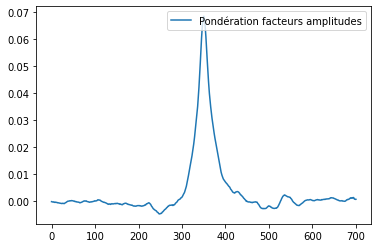

In [5]:
plt.figure()
plt.plot(inf,label = 'Pondération facteurs amplitudes')
plt.legend()
plt.show()


## III/ Visualisation des résultats pour tous les camions 

In [6]:
def lignes_influence_mt_amp(capteurs,nbre_camions,l2_reg=None, tv_reg=None):
    
    """
        Données : 
            - capteurs : chiffre appartenant à [3,4,6,7] identifiant un capteur
            - nbre_camions : nombre de camions sur lesquels faire les calculs de la LI
            - l2_reg : Régularisation L2
            - tv_reg : Régularisation TV
        Sorties :
            - Hc : Liste des lignes d'influence par capteur
        Fonction : Retourne la liste des lignes d'influence par capteur avec régularisation et facteurs d'amplitudes
    
    """
    import numpy as np
    from Bwifsttar import load_senlis_modified,calibration_mt_amp
    
    Hc = np.empty(len(capteurs),dtype=object)#liste des lignes d'influence (autant que de capteurs à tester)
        
    for i,capteur in enumerate(capteurs):
        calibration_trucks,traffic_trucks = load_senlis_modified(selected=capteur) #[3,4,6,7]
        
        if(nbre_camions<=len(calibration_trucks)):
            
            calibration_trucks = calibration_trucks[0:nbre_camions]
            h = calibration_mt_amp(calibration_trucks,l2_reg,tv_reg)
            Hc[i] = h
        
        else:
            print("Nombre de camions doit être inférieur ou égal à : ",len(calibration_trucks))
        
        
    return Hc


def multi_viz_amp(Hs,capteurs,l2_reg=None, tv_reg=None):
    """
        Données :
            - Hs : Liste des lignes d'influence par capteur
            - capteurs : liste des capteurs sur lesquels chargés les camions
            - l2_reg : Régularisation L2
            - tv_reg : Régularisation TV
        Sorties :
            - Void
        Fonction : Fonction qui affiche pour chaque capteur les reconstructions des signaux sur le nombre
        de camions voulu avec possibilité de régularisation
    """
    from Bwifsttar import load_senlis_modified,show_calibration
    import matplotlib.pyplot as plt
    for i in range(len(Hs)):
        try:
            print("Capteur : ",capteurs[i])


            calibration_trucks,traffic_trucks = load_senlis_modified(selected=capteurs[i]) #[3,4,6,7]
            print("*****CALIBRATION*****")
            plt.figure()
            show_calibration(calibration_trucks, Hc_6[i])
            plt.figure()
            print("*****TRAFFIC*****")
            show_calibration(traffic_trucks, Hc_6[i])

            print("Echec capteur n° : ",capteurs[i])
            plt.show()
        except:
            
            continue

### III.1 Regularization with TV_reg

In [7]:
#show_calibration(calibration_trucks, inf_tv_reg)
capteurs = [3,4,6,7]
#capteurs =[6]
Hc_6 = lignes_influence_mt_amp(capteurs,12,tv_reg={'strength': 1e2, 'cutoff': 0.95})


Alphas finaux :  [0.99999277 1.00023322 1.00039534 0.9997654  0.99971593 0.99924522
 0.99906682 0.99841124 0.99910643 0.99887528]
Alphas finaux :  [1.00000383 0.99985646 0.99971732 0.99898155 0.99959821 0.99952971
 0.99940864 0.99905438 0.9991801  0.99874882 0.99894142 0.99902309]
Alphas finaux :  [0.99995068 0.99973542 0.99840037 0.99910812 0.99913218 0.99871379
 0.9972225  0.99759873 0.99712686 0.99705102 0.99723104]
Alphas finaux :  [1.00000045 1.00004677 0.99991587 0.99953333 0.99963691 0.99951472
 0.9995326 ]


Capteur :  3
*****CALIBRATION*****


<Figure size 432x288 with 0 Axes>

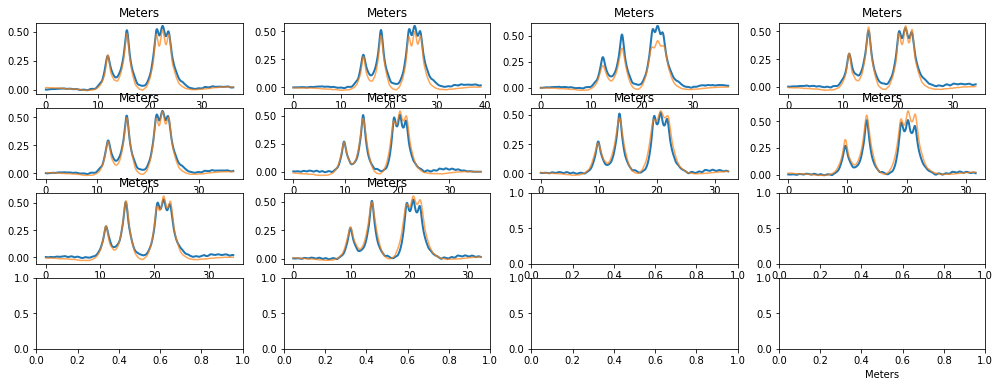

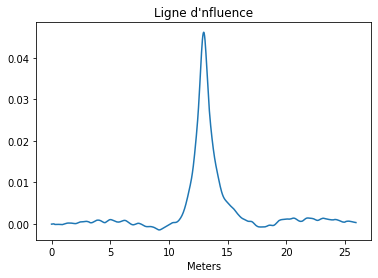

*****TRAFFIC*****


<Figure size 432x288 with 0 Axes>

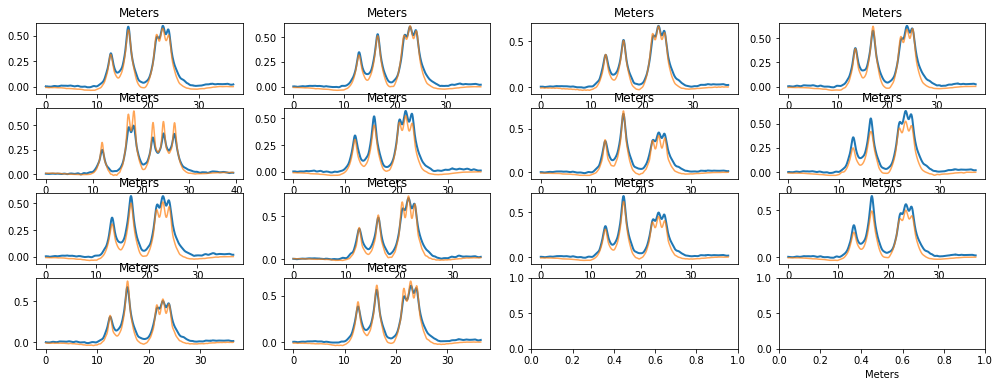

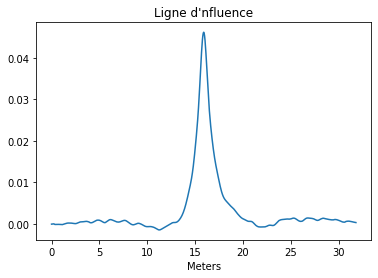

Echec capteur n° :  3
Capteur :  4
*****CALIBRATION*****


<Figure size 432x288 with 0 Axes>

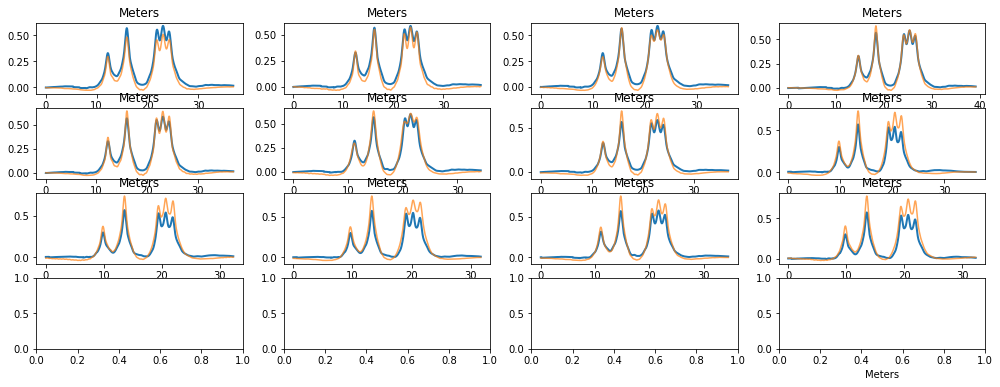

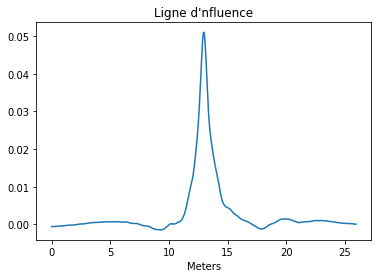

*****TRAFFIC*****


<Figure size 432x288 with 0 Axes>

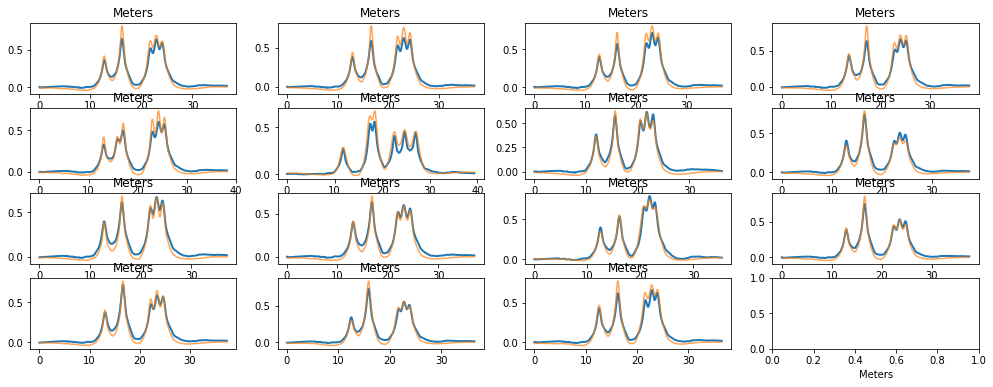

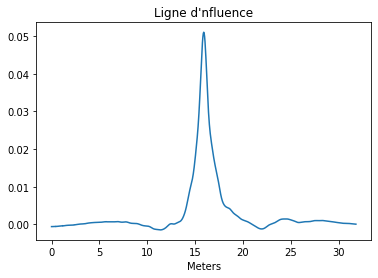

Echec capteur n° :  4
Capteur :  6
*****CALIBRATION*****


<Figure size 432x288 with 0 Axes>

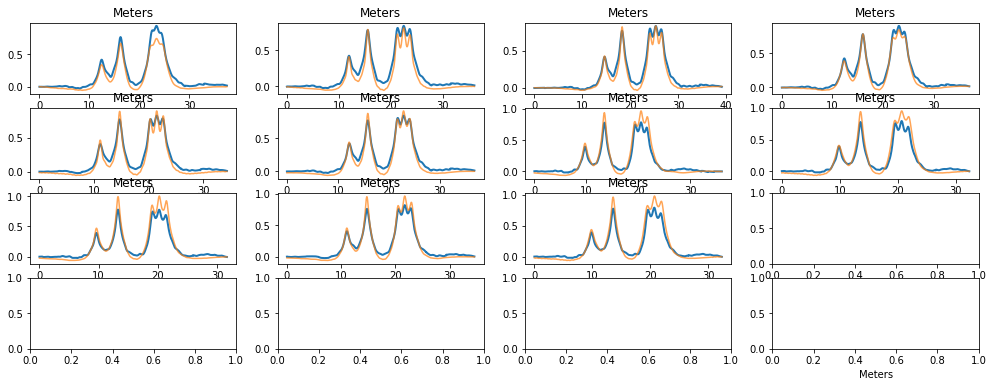

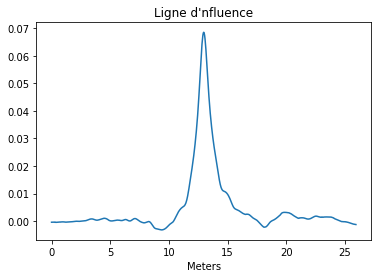

*****TRAFFIC*****


<Figure size 432x288 with 0 Axes>

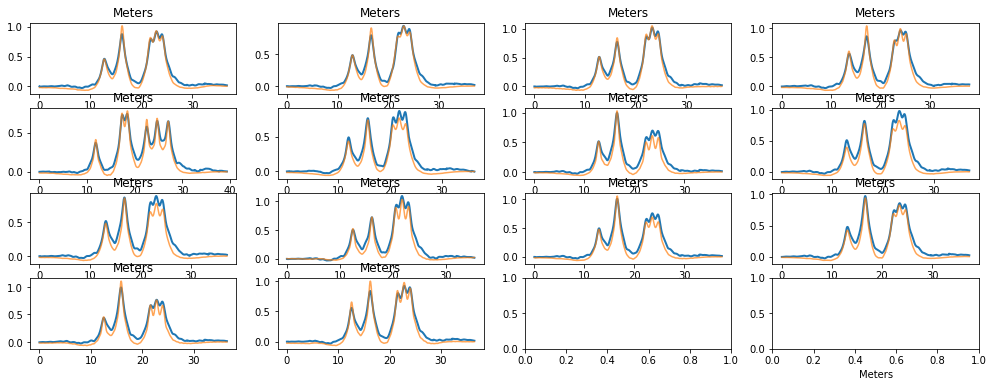

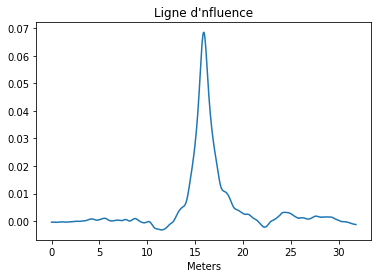

Echec capteur n° :  6
Capteur :  7
*****CALIBRATION*****


<Figure size 432x288 with 0 Axes>

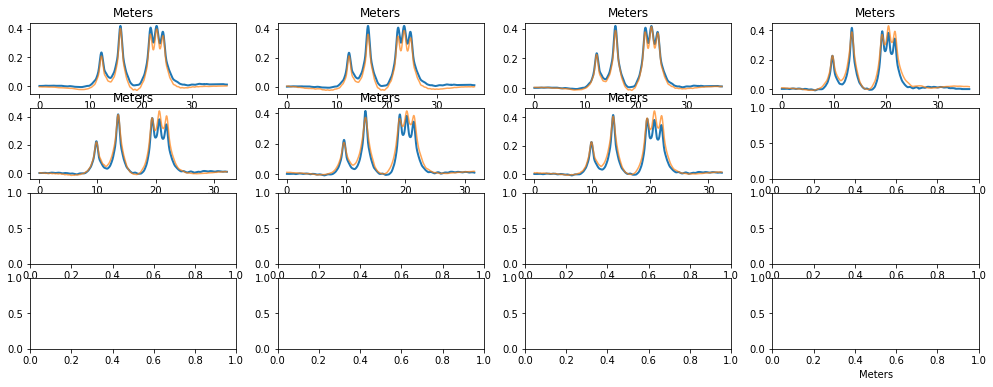

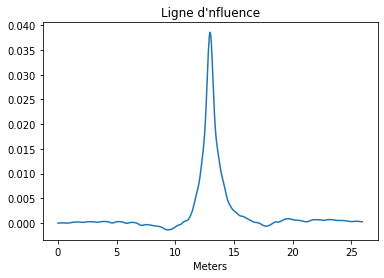

*****TRAFFIC*****


<Figure size 432x288 with 0 Axes>

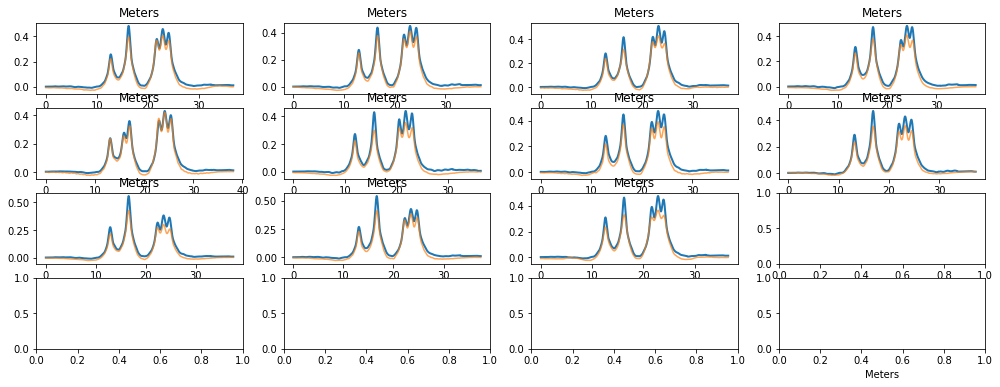

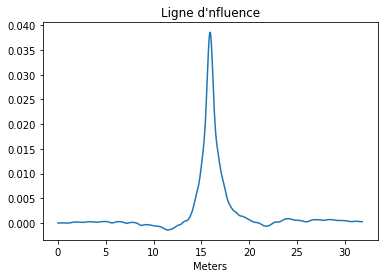

Echec capteur n° :  7


In [8]:
multi_viz_amp(Hc_6,capteurs)

### III.2 Regularization with l2_reg


In [9]:
capteurs = [3,4,6,7]
#capteurs =[6]
Hc_6 = lignes_influence_mt_amp(capteurs,12,l2_reg={'strength': 1e2, 'cutoff': 0.05})


Alphas finaux :  [1.0000072  1.00029619 1.00046201 0.9997493  0.99969584 0.9991524
 0.9989498  0.99820967 0.99901251 0.99873395]
Alphas finaux :  [1.00131569 1.00050402 1.00004007 0.99847847 0.99941372 0.9988889
 0.99849435 0.99659114 0.99705467 0.99539574 0.9965238  0.99636475]
Alphas finaux :  [1.00851857 1.00789522 1.00819798 1.00143971 0.99946503 0.99796665
 0.98300505 0.98497775 0.98195644 0.98549487 0.98241672]
Alphas finaux :  [1.00000979 1.00005592 0.99992131 0.99951791 0.99962449 0.99949897
 0.99951633]


Capteur :  3
*****CALIBRATION*****


<Figure size 432x288 with 0 Axes>

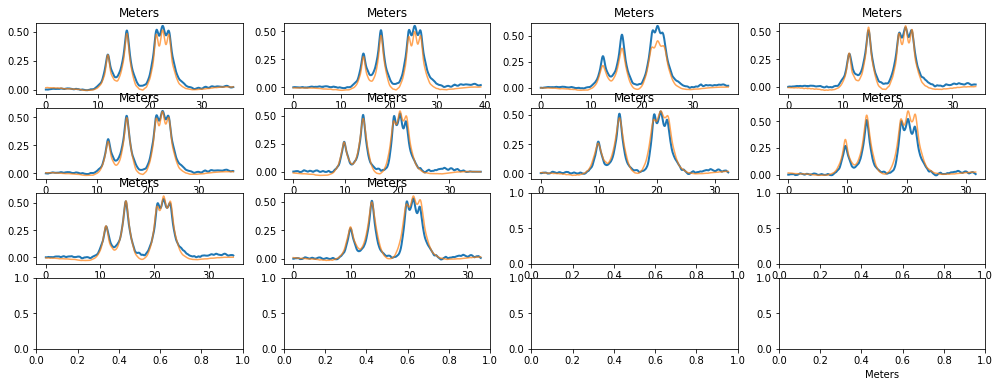

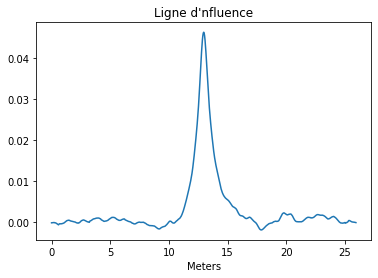

*****TRAFFIC*****


<Figure size 432x288 with 0 Axes>

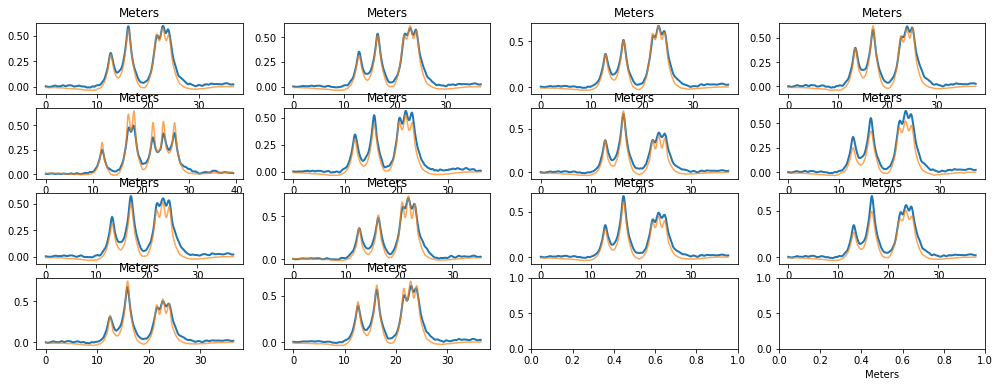

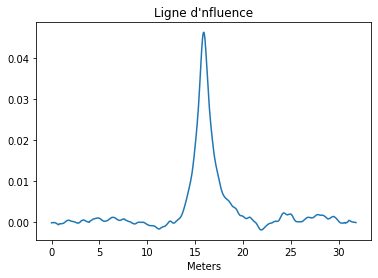

Echec capteur n° :  3
Capteur :  4
*****CALIBRATION*****


<Figure size 432x288 with 0 Axes>

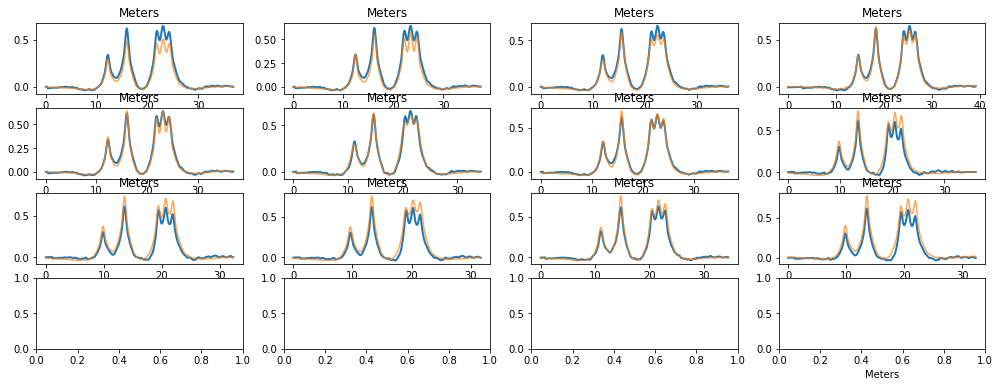

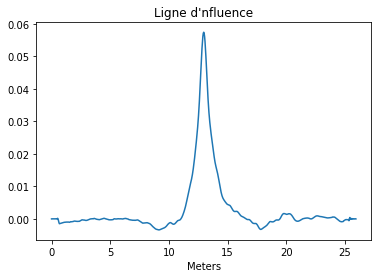

*****TRAFFIC*****


<Figure size 432x288 with 0 Axes>

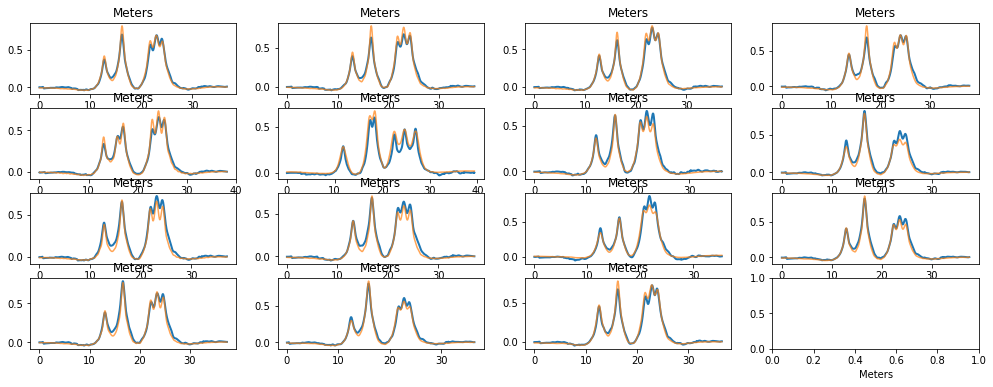

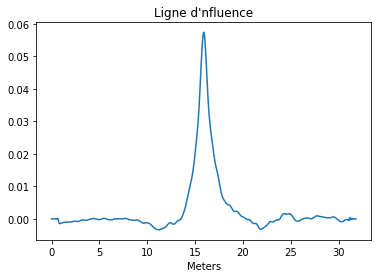

Echec capteur n° :  4
Capteur :  6
*****CALIBRATION*****


<Figure size 432x288 with 0 Axes>

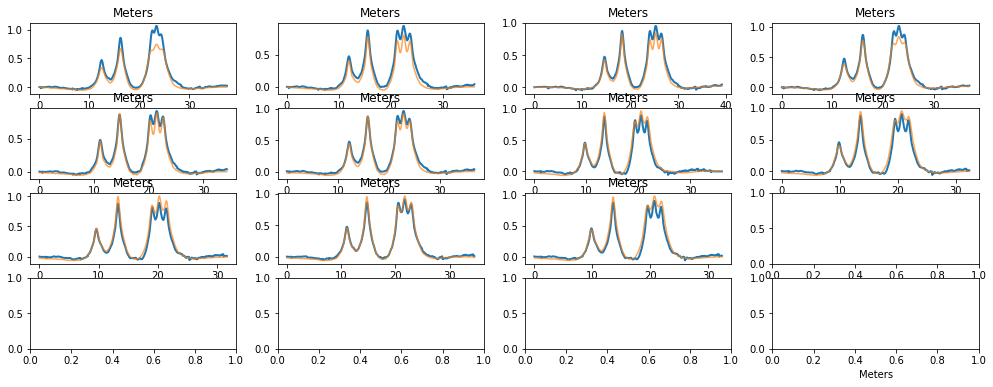

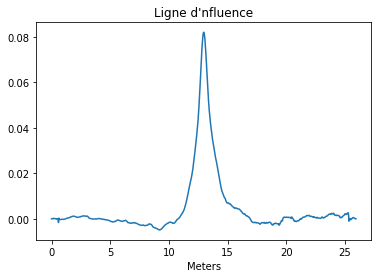

*****TRAFFIC*****


<Figure size 432x288 with 0 Axes>

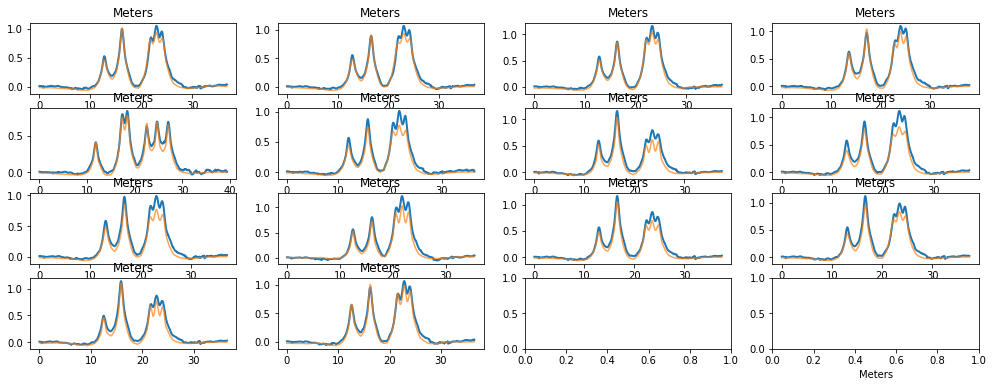

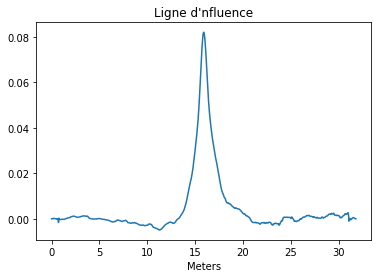

Echec capteur n° :  6
Capteur :  7
*****CALIBRATION*****


<Figure size 432x288 with 0 Axes>

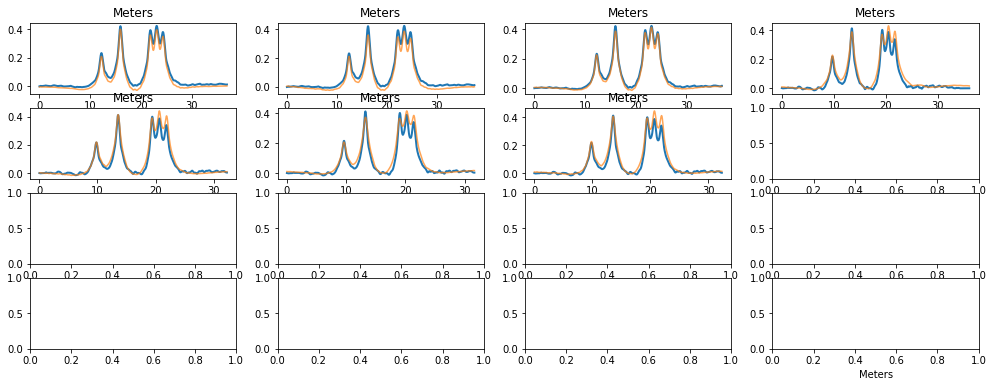

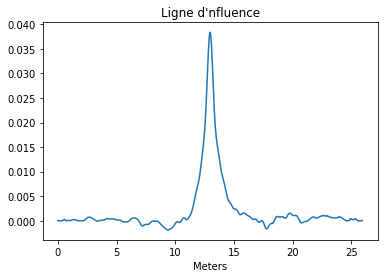

*****TRAFFIC*****


<Figure size 432x288 with 0 Axes>

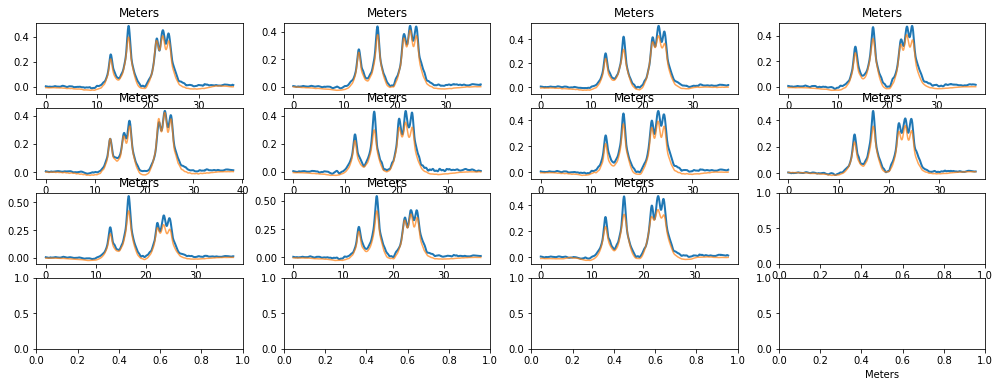

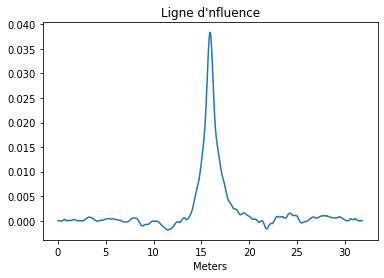

Echec capteur n° :  7


In [10]:
multi_viz_amp(Hc_6,capteurs)